In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt

In [2]:
movies_df = pd.read_csv('movies.csv')
#Storing the user information into a pandas dataframe
ratings_df = pd.read_csv('ratings.csv')
#Head is a function that gets the first N rows of a dataframe. N's default is 5.

# Preprocessing
first let us look at movies datafram

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Let's also remove the year from the **title** column by using pandas' replace function and store in a new **year** column.

In [4]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don't conflict with movies that have years in their titles
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())
movies_df.head()

<ipython-input-4-2517c676119f>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')


,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


With that, let's also split the values in the Genres column into a list of Genres to simplify for future use. This can be achieved by applying Python's split string function on the correct column.

In [5]:
#Every genre is separated by a | so we simply have to call the split function on |
movies_df['genres'] = movies_df.genres.str.split('|')
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


Since keeping genres in a list format isn't optimal for the content-based recommendation system technique, we will use the One Hot Encoding technique to convert the list of genres to a vector where each column corresponds to one possible value of the feature. This encoding is needed for feeding categorical data. In this case, we store every different genre in columns that contain either 1 or 0. 1 shows that a movie has that genre and 0 shows that it doesn't. Let's also store this dataframe in another variable since genres won't be important for our first recommendation system.

In [6]:
#Copying the movie dataframe into a new one since we won't need to use the genre information in our first case.
moviesWithGenres_df = movies_df.copy()

#For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
for index, row in movies_df.iterrows():
    for genre in row['genres']:
        moviesWithGenres_df.at[index, genre] = 1
#Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
moviesWithGenres_df = moviesWithGenres_df.fillna(0)
moviesWithGenres_df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, let's look at the ratings dataframe.

In [7]:
ratings_df.head()

,userId,movieId,rating
0,1,169,2.5
1,1,2471,3.0
2,1,48516,5.0
3,2,2571,3.5
4,2,109487,4.0


Every row in the ratings dataframe has a user id associated with at least one movie, a rating and a timestamp showing when they reviewed it. We won't be needing the timestamp column, so let's drop it to save memory.

Let's begin by creating an input user to recommend movies to:

Notice: To add more movies, simply increase the amount of elements in the userInput. Feel free to add more in! Just be sure to write it in with capital letters and if a movie starts with a "The", like "The Matrix" then write it in like this: 'Matrix, The'.

In [8]:
userInput = [
            {'title':'Breakfast Club, The', 'rating':5},
            {'title':'Toy Story', 'rating':3.5},
            {'title':'Jumanji', 'rating':2},
            {'title':"Pulp Fiction", 'rating':5},
            {'title':'Akira', 'rating':4.5}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,"Breakfast Club, The",5.0
1,Toy Story,3.5
2,Jumanji,2.0
3,Pulp Fiction,5.0
4,Akira,4.5


Add movieId to input user

With the input complete, let's extract the input movie's ID's from the movies dataframe and add them into it.

We can achieve this by first filtering out the rows that contain the input movie's title and then merging this subset with the input dataframe. We also drop unnecessary columns for the input to save memory space.

In [9]:
#Filtering out the movies by title
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]
#Then merging it so we can get the movieId. It's implicitly merging it by title.
inputMovies = pd.merge(inputId, inputMovies)
#Dropping information we won't use from the input dataframe
inputMovies = inputMovies.drop('genres', 1)
#Final input dataframe
#If a movie you added in above isn't here, then it might not be in the original 
#dataframe or it might spelled differently, please check capitalisation.
inputMovies

,movieId,title,year,rating
0,1,Toy Story,1995,3.5
1,2,Jumanji,1995,2.0
2,296,Pulp Fiction,1994,5.0
3,1274,Akira,1988,4.5
4,1968,"Breakfast Club, The",1985,5.0


# Content-Based recommendation system
Now, let's take a look at how to implement Content-Based or Item-Item recommendation systems. This technique attempts to figure out what a users favourite aspects of an item is, and then recommends items that present those aspects. In our case, we're going to try to figure out the input's favorite genres from the movies and ratings given.

We're going to start by learning the input's preferences, so let's get the subset of movies that the input has watched from the Dataframe containing genres defined with binary values.


In [10]:
#Filtering out the movies from the input
userMovies = moviesWithGenres_df[moviesWithGenres_df['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293,296,Pulp Fiction,"[Comedy, Crime, Drama, Thriller]",1994,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1246,1274,Akira,"[Action, Adventure, Animation, Sci-Fi]",1988,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1885,1968,"Breakfast Club, The","[Comedy, Drama]",1985,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We'll only need the actual genre table, so let's clean this up a bit by resetting the index and dropping the movieId, title, genres and year columns.

In [11]:
#Resetting the index to avoid future issues
userMovies = userMovies.reset_index(drop=True)
#Dropping unnecessary issues due to save memory and to avoid issues
userGenreTable = userMovies.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
userGenreTable

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we're ready to start learning the input's preferences!

To do this, we're going to turn each genre into weights. We can do this by using the input's reviews and multiplying them into the input's genre table and then summing up the resulting table by column. This operation is actually a dot product between a matrix and a vector, so we can simply accomplish by calling the Pandas "dot" function.

In [12]:
inputMovies['rating']

0    3.5
1    2.0
2    5.0
3    4.5
4    5.0
Name: rating, dtype: float64

In [13]:
##

In [14]:
#Dot produt to get weights
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])
#The user profile
userProfile

Adventure             10.0
Animation              8.0
Children               5.5
Comedy                13.5
Fantasy                5.5
Romance                0.0
Drama                 10.0
Action                 4.5
Crime                  5.0
Thriller               5.0
Horror                 0.0
Mystery                0.0
Sci-Fi                 4.5
IMAX                   0.0
Documentary            0.0
War                    0.0
Musical                0.0
Western                0.0
Film-Noir              0.0
(no genres listed)     0.0
dtype: float64

Now, we have the weights for every of the user's preferences. This is known as the User Profile. Using this, we can recommend movies that satisfy the user's preferences.

Let's start by extracting the genre table from the original dataframe:

In [15]:
#Now let's get the genres of every movie in our original dataframe
genreTable = moviesWithGenres_df.set_index(moviesWithGenres_df['movieId'])
#And drop the unnecessary information
genreTable = genreTable.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
genreTable.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
genreTable.shape

(34208, 20)

With the input's profile and the complete list of movies and their genres in hand, we're going to take the weighted average of every movie based on the input profile and recommend the top twenty movies that most satisfy it.

In [17]:
#Multiply the genres by the weights and then take the weighted average
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df.head()

movieId
1    0.594406
2    0.293706
3    0.188811
4    0.328671
5    0.188811
dtype: float64

In [18]:
#Sort our recommendations in descending order
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)
#Just a peek at the values
recommendationTable_df.head()

movieId
5018      0.748252
26093     0.734266
27344     0.720280
148775    0.685315
6902      0.678322
dtype: float64

In [19]:
#converting series to frames
rt_df=pd.Series.to_frame(recommendationTable_df)


Now here's the recommendation table!



In [20]:
cbrs=pd.merge(rt_df,movies_df,on='movieId')
cbrs.head(10)                                            

,movieId,0,title,genres,year
0,5018,0.748252,Motorama,"[Adventure, Comedy, Crime, Drama, Fantasy, Mys...",1991
1,26093,0.734266,"Wonderful World of the Brothers Grimm, The","[Adventure, Animation, Children, Comedy, Drama...",1962
2,27344,0.720280,Revolutionary Girl Utena: Adolescence of Utena...,"[Action, Adventure, Animation, Comedy, Drama, ...",1999
3,148775,0.685315,Wizards of Waverly Place: The Movie,"[Adventure, Children, Comedy, Drama, Fantasy, ...",2009
4,6902,0.678322,Interstate 60,"[Adventure, Comedy, Drama, Fantasy, Mystery, S...",2002
5,117646,0.678322,Dragonheart 2: A New Beginning,"[Action, Adventure, Comedy, Drama, Fantasy, Th...",2000
6,122787,0.671329,The 39 Steps,"[Action, Adventure, Comedy, Crime, Drama, Thri...",1959
7,64645,0.671329,The Wrecking Crew,"[Action, Adventure, Comedy, Crime, Drama, Thri...",1968
8,81132,0.671329,Rubber,"[Action, Adventure, Comedy, Crime, Drama, Film...",2010
9,2987,0.664336,Who Framed Roger Rabbit?,"[Adventure, Animation, Children, Comedy, Crime...",1988


In [21]:
cbrs.drop(cbrs.columns[1], axis=1, inplace=True)
cbrs.head(10)

,movieId,title,genres,year
0,5018,Motorama,"[Adventure, Comedy, Crime, Drama, Fantasy, Mys...",1991
1,26093,"Wonderful World of the Brothers Grimm, The","[Adventure, Animation, Children, Comedy, Drama...",1962
2,27344,Revolutionary Girl Utena: Adolescence of Utena...,"[Action, Adventure, Animation, Comedy, Drama, ...",1999
3,148775,Wizards of Waverly Place: The Movie,"[Adventure, Children, Comedy, Drama, Fantasy, ...",2009
4,6902,Interstate 60,"[Adventure, Comedy, Drama, Fantasy, Mystery, S...",2002
5,117646,Dragonheart 2: A New Beginning,"[Action, Adventure, Comedy, Drama, Fantasy, Th...",2000
6,122787,The 39 Steps,"[Action, Adventure, Comedy, Crime, Drama, Thri...",1959
7,64645,The Wrecking Crew,"[Action, Adventure, Comedy, Crime, Drama, Thri...",1968
8,81132,Rubber,"[Action, Adventure, Comedy, Crime, Drama, Film...",2010
9,2987,Who Framed Roger Rabbit?,"[Adventure, Animation, Children, Comedy, Crime...",1988


Advantages and Disadvantages of Content-Based Filtering

Advantages
1. Learns user's preferences 
2. Highly personalized for the user

Disadvantages
1. Doesn't take into account what others think of the item, so low quality item recommendations might happen
2. Extracting data is not always intuitive
3. Determining what characteristics of the item the user dislikes or likes is not always obvious

# Collaborative Filtering

The first technique we're going to take a look at is called Collaborative Filtering, which is also known as User-User Filtering. As hinted by its alternate name, this technique uses other users to recommend items to the input user. It attempts to find users that have similar preferences and opinions as the input and then recommends items that they have liked to the input. There are several methods of finding similar users (Even some making use of Machine Learning), and the one we will be using here is going to be based on the Pearson Correlation Function.
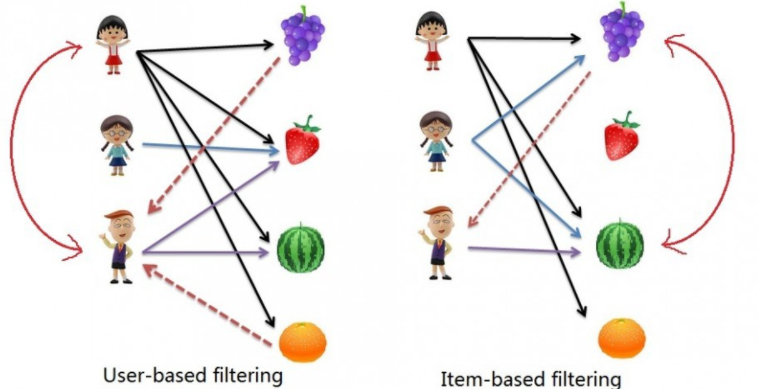

The process for creating a User Based recommendation system is as follows:

1. Select a user with the movies the user has watched
2. Based on his rating to movies, find the top X neighbours
3. Get the watched movie record of the user for each neighbour.
4. Calculate a similarity score using some formula
5. Recommend the items with the highest score

In [22]:
#inputs from user
inputMovies

,movieId,title,year,rating
0,1,Toy Story,1995,3.5
1,2,Jumanji,1995,2.0
2,296,Pulp Fiction,1994,5.0
3,1274,Akira,1988,4.5
4,1968,"Breakfast Club, The",1985,5.0


**The users who has seen the same movies**

Now with the movie ID's in our input, we can now get the subset of users that have watched and reviewed the movies in our input.

In [23]:
#Filtering out users that have watched movies that the input has watched and storing it
userSubset = ratings_df[ratings_df['movieId'].isin(inputMovies['movieId'].tolist())]
userSubset.head()

,userId,movieId,rating
19,4,296,4.0
441,12,1968,3.0
479,13,2,2.0
531,13,1274,5.0
681,14,296,2.0


We now group up the rows by user ID.

In [24]:
#Groupby creates several sub dataframes where they all have the same value in the column specified as the parameter
userSubsetGroup = userSubset.groupby(['userId'])

Let's look at one of the users, e.g. the one with userID=1130.

In [25]:
userSubsetGroup.get_group(1130)

,userId,movieId,rating
104167,1130,1,0.5
104168,1130,2,4.0
104214,1130,296,4.0
104363,1130,1274,4.5
104443,1130,1968,4.5


Let's also sort these groups so the users that share the most movies in common with the input have higher priority. This provides a richer recommendation since we won't go through every single user.

In [26]:
#Sorting it so users with movie most in common with the input will have priority
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]),reverse=True )

Now let's look at the first user.

In [27]:
userSubsetGroup[0:3]

[(75,
        userId  movieId  rating
  7507      75        1     5.0
  7508      75        2     3.5
  7540      75      296     5.0
  7633      75     1274     4.5
  7673      75     1968     5.0),
 (106,
        userId  movieId  rating
  9083     106        1     2.5
  9084     106        2     3.0
  9115     106      296     3.5
  9198     106     1274     3.0
  9238     106     1968     3.5),
 (686,
         userId  movieId  rating
  61336     686        1     4.0
  61337     686        2     3.0
  61377     686      296     4.0
  61478     686     1274     4.0
  61569     686     1968     5.0)]

**Similarity of users to input user**

Next, we are going to compare all users (not really all !!!) to our specified user and find the one that is most similar.
we're going to find out how similar each user is to the input through the Pearson Correlation Coefficient. It is used to measure the strength of a linear association between two variables. The formula for finding this coefficient between sets X and Y with N values can be seen in the image below.


The values given by the formula vary from r = -1 to r = 1, where 1 forms a direct correlation between the two entities (it means a perfect positive correlation) and -1 forms a perfect negative correlation.

In our case, a 1 means that the two users have similar tastes while a -1 means the opposite.

We will select a subset of users to iterate through. This limit is imposed because we don't want to waste too much time going through every single user.

In [28]:
userSubsetGroup = userSubsetGroup[0:100]

Now, we calculate the Pearson Correlation between input user and subset group, and store it in a dictionary, where the key is the user Id and the value is the coefficient.

In [29]:
#Store the Pearson Correlation in a dictionary, where the key is the user Id and the value is the coefficient
pearsonCorrelationDict = {}

#For every user group in our subset
for name, group in userSubsetGroup:
    #Let's start by sorting the input and current user group so the values aren't mixed up later on
    group = group.sort_values(by='movieId')
    inputMovies = inputMovies.sort_values(by='movieId')
    #Get the N for the formula
    nRatings = len(group)
    #Get the review scores for the movies that they both have in common
    temp_df = inputMovies[inputMovies['movieId'].isin(group['movieId'].tolist())]
    #And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp_df['rating'].tolist()
    #Let's also put the current user group reviews in a list format
    tempGroupList = group['rating'].tolist()
    #Now let's calculate the pearson correlation between two users, so called, x and y
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorrelationDict[name] = 0

In [30]:
pearsonCorrelationDict.items()

dict_items([(75, 0.8272781516947562), (106, 0.5860090386731182), (686, 0.8320502943378437), (815, 0.5765566601970551), (1040, 0.9434563530497265), (1130, 0.2891574659831201), (1502, 0.8770580193070299), (1599, 0.4385290096535153), (1625, 0.716114874039432), (1950, 0.179028718509858), (2065, 0.4385290096535153), (2128, 0.5860090386731196), (2432, 0.1386750490563073), (2791, 0.8770580193070299), (2839, 0.8204126541423674), (2948, -0.11720180773462392), (3025, 0.45124262819713973), (3040, 0.89514359254929), (3186, 0.6784622064861935), (3271, 0.26989594817970664), (3429, 0.0), (3734, -0.15041420939904673), (4099, 0.05860090386731196), (4208, 0.29417420270727607), (4282, -0.4385290096535115), (4292, 0.6564386345361464), (4415, -0.11183835382312353), (4586, -0.9024852563942795), (4725, -0.08006407690254357), (4818, 0.4885967564883424), (5104, 0.7674257668936507), (5165, -0.4385290096535153), (5547, 0.17200522903844556), (6082, -0.04728779924109591), (6207, 0.9615384615384616), (6366, 0.65779

In [31]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,userId
0,0.827278,75
1,0.586009,106
2,0.832050,686
3,0.576557,815
4,0.943456,1040


**The top x similar users to input user**

Now let's get the top 50 users that are most similar to the input.

In [32]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,userId
90,1.000000,1255
76,0.986928,599
92,0.971061,1519
79,0.965581,784
85,0.965060,1066


Now, let's start recommending movies to the input user.

#### Rating of selected users to all movies

We're going to do this by taking the weighted average of the ratings of the movies using the Pearson Correlation as the weight. But to do this, we first need to get the movies watched by the users in our **pearsonDF** from the ratings dataframe and then store their correlation in a new column called \_similarityIndex". This is achieved below by merging of these two tables.


In [33]:
topUsersRating=topUsers.merge(ratings_df, left_on='userId', right_on='userId', how='inner')
topUsersRating.head()

,similarityIndex,userId,movieId,rating
0,1.0,1255,1,3.0
1,1.0,1255,2,2.5
2,1.0,1255,10,3.5
3,1.0,1255,18,3.5
4,1.0,1255,19,3.5


Now all we need to do is simply multiply the movie rating by its weight (The similarity index), then sum up the new ratings and divide it by the sum of the weights.

We can easily do this by simply multiplying two columns, then grouping up the dataframe by movieId and then dividing two columns:

It shows the idea of all similar users to candidate movies for the input user:

In [34]:
#Multiplies the similarity by the user's ratings
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
topUsersRating.head()

,similarityIndex,userId,movieId,rating,weightedRating
0,1.0,1255,1,3.0,3.0
1,1.0,1255,2,2.5,2.5
2,1.0,1255,10,3.5,3.5
3,1.0,1255,18,3.5,3.5
4,1.0,1255,19,3.5,3.5


In [35]:
#Applies a sum to the topUsers after grouping it up by userId
tempTopUsersRating = topUsersRating.groupby('movieId').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating
movieId,,
1,39.380931,145.043560
2,39.359350,95.822467
3,9.784889,25.597844
4,1.446442,3.537543
5,9.868434,23.540577


In [36]:
#Creates an empty dataframe
recommendation_df1 = pd.DataFrame()
#Now we take the weighted average
recommendation_df1['movieId'] = tempTopUsersRating.index
recommendation_df1['weighted average recommendation score'] = (tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex'])

recommendation_df1.head()


,movieId,weighted average recommendation score
0,1,NaN
1,2,3.683091
2,3,2.434554
3,4,2.616059
4,5,2.445686


In [37]:
recommendation_df1 = recommendation_df1.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df1.head(10)

,movieId,weighted average recommendation score
326,479,5.0
4566,47999,5.0
3814,8235,5.0
5022,67408,5.0
4541,46965,5.0
2575,4438,5.0
5489,93790,5.0
2488,4226,5.0
416,613,5.0
2443,4128,5.0


In [38]:
cf=pd.merge(recommendation_df1,movies_df,on='movieId')
cf = cf.drop('weighted average recommendation score', 1)
cf.head(10)

,movieId,title,genres,year
0,479,Judgment Night,"[Action, Crime, Thriller]",1993
1,47999,Jesus Camp,"[Documentary, Drama]",2006
2,8235,Safety Last!,"[Action, Comedy, Romance]",1923
3,67408,Monsters vs. Aliens,"[Animation, Sci-Fi, IMAX]",2009
4,46965,Snakes on a Plane,"[Action, Comedy, Horror, Thriller]",2006
5,4438,"Fist of Fury (Chinese Connection, The) (Jing w...","[Action, Drama, Romance, Thriller]",1972
6,93790,Detachment,[Drama],2011
7,4226,Memento,"[Mystery, Thriller]",2000
8,613,Jane Eyre,"[Drama, Romance]",1996
9,4128,"Lost Boys, The","[Comedy, Horror, Thriller]",1987


Now let's sort it and see the top 20 movies that the algorithm recommended!

### Advantages and Disadvantages of Collaborative Filtering

##### Advantages

*   Takes other user's ratings into consideration
*   Doesn't need to study or extract information from the recommended item
*   Adapts to the user's interests which might change over time

##### Disadvantages

*   Approximation function can be slow
*   There might be a low of amount of users to approximate
*   Privacy issues when trying to learn the user's preferences
